In [1]:
from __future__ import print_function
import os
import cv2
import numpy as np
import tensorflow as tf
from src.model import Model as Attn_Model
from src.baseline_classify import Model as Clfy_Model
from src.data_loader_seq_classify import dataLoader
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [25]:
plt.rcParams['figure.figsize'] = (3.0, 3.0)  # set default size of plots

### Main

In [3]:
# Load train dataset
data = dataLoader(directory='./dataset', width=16, height=16,\
                  dataset_dir='test_cropped',\
                  dataset_name='test.txt', max_steps=7, mode='Test')

All data-loaded!


In [4]:
# data1 = data.all_data
# data2 = data.all_seq_data

# print(len(data1))
# print(len(data2))

In [5]:
test_loader = data.gen_data_batch(batch_size=44)

In [12]:
lbl_seq=[]
lbl_img=[]

In [13]:
for i in range(27):
    _, _, image_batch, label_batch = next(test_loader)
    lbl_seq.append(label_batch)
    lbl_img.append(image_batch)

In [14]:
len(lbl_seq)

27

In [15]:
ll = lbl_seq[0]

In [16]:
len(ll)

44

In [21]:
ll1 = ll[0]
len(ll1)

3

In [17]:
l1 = lbl_img[0]

In [18]:
len(l1)

44

In [19]:
l2 = l1[0]

In [20]:
len(l2)

3

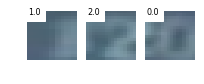

In [26]:
# Plot original image
fig,ax = plt.subplots(1, len(l2))
for T in range(len(l2)):
    ax[T].imshow((l2[T] + 1)*127.5)
    ax[T].text(0, 1, (ll1[T]), color='black', backgroundcolor='white', fontsize=8)
    ax[T].axis('off')

plt.show()

### Prediction_char

In [3]:
# Test dataset
img_size    = (16,16)
max_steps   = 7
width       = img_size[0]
height      = img_size[1]
batch_size  = 44

In [5]:
def valid_pred_bboxs(pred_bboxes):
    """
    The first step and last step are start and stop state
    """
    def box_threshold(left, top, width, height):
        valid_box = False
        # If the threshold box is less than 10
        if width * height < 10:
            valid_box = False
        elif int(left) == 0 and int(top) == 0 and\
             int(width) == 0 and int(height) == 0:
            valid_box = False
        else:
            valid_box = True

        return valid_box

    valid_pred_bboxs = []
    for t in range(batch_size):
        interm_pred_bboxs = []
        for T in range(max_steps):
            # Ignore first and last prediction
            if T != 0 and T+1 != max_steps:
                # Predicted bounding box
                smple_left   = pred_bboxes[t][T][0][0]
                smple_top    = pred_bboxes[t][T][0][1]
                smple_width  = pred_bboxes[t][T][0][2]
                smple_height = pred_bboxes[t][T][0][3]
                # Check if the box is valid
                vld_bbx_pred = box_threshold(left=smpl_left, top=smple_top,\
                                     width=smple_width, height=smple_height)
                # Collect if valid box
                if vld_bbx_pred:
                    interm_pred_bboxs.append([smple_left, smple_top, smple_width, smple_height])
        # Collect
        valid_pred_bboxs.append(interm_pred_bboxs)

    return valid_pred_bboxs

def crop_and_resize(images, bboxes):
    images_crop_resize = []
    for t in range(len(bboxes)):
        image = images[t] # Sample image
        bbox  = bboxes[t] # Sample predictions
        interm_images_crop_resize = []
        # Loop through predictions
        for bbx in bbox:
            sample_left   = abs(int(bbx[0]))
            sample_top    = abs(int(bbx[1]))
            sample_width  = abs(int(bbx[2]))
            sample_height = abs(int(bbx[3]))

            image_patch = image[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width, :]
            # Zooming
            image_patch_rz = cv2.resize(image_patch, (width, height), interpolation = cv2.INTER_AREA)
            # Normalize image between -1 and 1
            image_patch_rz = image_patch_rz /127.5 - 1.0
            # Collect
            interm_images_crop_resize.append(image_patch_rz)
        # Append to main
        images_crop_resize.append(interm_images_crop_resize)

    return images_crop_resize

In [6]:
# Load Attention Model
attn_model = Attn_Model(dim_feature=[49, 128], dim_hidden=128, n_time_step=7,
              alpha_c=1.0, image_height=64, image_width=64, mode='test')
# Load
clfy_model = Clfy_Model(image_height=16, image_width=16, l2=0.0002, mode='test')

In [7]:
test_loader = data.gen_data_batch(batch_size)
n_examples  = data.max_length
n_iters     = int(np.ceil(float(n_examples)/batch_size))
# Total Char
total_char = 0.0
# Summary
print("Data size:  %d" %n_examples)
print("Batch size: %d" %batch_size)
print("Iterations: %d" %n_iters)

Data size:  13068
Batch size: 44
Iterations: 297


In [8]:
# Build model
pred_bboxs_, _    = attn_model.build_test_model()
_, predictions    = clfy_model.build_test_model()
# Classification score
check_predictions = tf.equal(predictions, tf.argmax(clfy_model.labels, axis=1))
accuracy = tf.reduce_mean(tf.cast(check_predictions, tf.float32))

# Set GPU options
config = tf.GPUOptions(allow_growth=True)

CNN build model sucess!
Classification build model sucess!


In [9]:
sess.close()

NameError: name 'sess' is not defined

In [17]:
del predicted_bboxs

In [23]:
image_batch, image_norm_batch, label_batch = next(test_loader)
print(image_batch.shape)

(44, 64, 64, 3)


In [10]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    # Tensorboard summary path
    saver = tf.train.Saver()

    print("Start testing with Classification Model with random weights...")
    print("Start testing with Attention Model with random weights...")

    total_acc = 0.0

    image_batch, image_norm_batch, label_batch = next(test_loader)
    ## Box Prediction
    feed_dict = {attn_model.images: image_norm_batch,
                 attn_model.drop_prob: 1.0}
    # Run bounding box prediction
    predicted_bboxs = sess.run(pred_bboxs_, feed_dict)
    vald_prdct_bbxs = valid_pred_bboxs(pred_bboxes=predicted_bboxs)
    images_crop_rez = crop_and_resize(images=image_batch, bboxes=vald_prdct_bbxs)
    images_crop_rez = np.array(images_crop_rez)
    print()
    ## Digit classification
    for k in range(len(images_crop_rez)):
        each_predt_images = np.array(images_crop_rez[k])
        each_image_labels = label_batch[k]
        # Check if prediction batch equals label_batch,
        # if not select upto of the label batch
        if len(each_predt_images) > len(each_image_labels):
            each_predt_images = each_predt_images[0:len(each_image_labels), :, :, :]
        elif len(each_predt_images) < len(each_image_labels):
            each_predt_images_trim = each_predt_images[0:len(each_predt_images), :, :, :]
        # Increment total characters using the orginal sequence not the trim
        total_char += len(each_image_labels)
        ## Digit Prediction
        feed_dict = {clfy_model.images: each_predt_images_trim,
                     clfy_model.labels: each_image_labels,
                     clfy_model.drop_prob: 1.0}
        # Run bounding
        accu, pred = sess.run([accuracy, predictions], feed_dict)

Start testing with Classification Model with random weights...
Start testing with Attention Model with random weights...


IndexError: invalid index to scalar variable.

In [11]:
len(predicted_bboxs)

7

In [30]:
def box_threshold(left, top, width, height):
    valid_box = False
    print(width * height)
    # If the threshold box is less than 10
    if width * height < 10:
        valid_box = False
    elif int(left) == 0 and int(top) == 0 and\
         int(width) == 0 and int(height) == 0:
        valid_box = False
    else:
        valid_box = True

    return valid_box

In [31]:
def valid_pred_bboxs(pred_bboxes):
    valid_pred_bboxs = []
    for t in range(batch_size):
        interm_pred_bboxs = []
        for T in range(max_steps):
            # Ignore first and last prediction
            if T != 0 and T+1 != max_steps:
                # Predicted bounding box
                smple_left   = abs(pred_bboxes[T][t][0])
                smple_top    = abs(pred_bboxes[T][t][1])
                smple_width  = abs(pred_bboxes[T][t][2])
                smple_height = abs(pred_bboxes[T][t][3])
                # Check if the box is valid
                vld_bbx_pred = box_threshold(left=smple_left, top=smple_top,\
                                     width=smple_width, height=smple_height)
                # Collect if valid box
                if vld_bbx_pred:
                    interm_pred_bboxs.append([smple_left, smple_top, smple_width, smple_height])
        # Collect
        valid_pred_bboxs.append(interm_pred_bboxs)

In [32]:
bboxes = valid_pred_bboxs(pred_bboxes=predicted_bboxs)

0.014883008
0.011749274
0.0061300127
0.0012396609
0.009899711
0.0005871639
0.0030439636
0.009103718
0.015955519
0.022211248
0.0006621551
0.00047915822
0.0060281255
0.013906489
0.021707619
1.50129745e-05
7.1338914e-06
0.0005797923
0.0025435947
0.0059760935
0.00079473504
0.0010871042
0.0021354575
0.00086879206
0.008607927
0.0009475483
0.00014701828
8.925074e-05
0.0038721135
0.011279314
0.0006327236
0.00057044416
0.0011321605
0.0013351438
0.0014274555
0.00054664497
0.00027542718
0.005289813
0.01759072
0.034720622
0.0010515897
0.0012190399
0.0059653562
0.01121058
0.015657023
0.0021165193
0.001138083
0.00803649
0.016679928
0.025031846
8.109698e-05
0.0006093914
0.0018771905
0.0029881801
0.0036351036
0.0001635474
0.001063722
0.006017875
0.012763721
0.01936726
0.0002923064
0.000919457
0.0004814664
0.0048850607
0.01188092
0.00077671075
0.00026821886
5.2076513e-05
0.0017610989
0.005991316
0.011320448
0.010685269
0.009473941
0.00851423
0.0078033702
0.00031582217
0.00028620832
0.0034124048
0.00979

In [29]:
len(bboxes)

TypeError: object of type 'NoneType' has no len()